# NF example

This is an example about how using NumOfFeatures to reduce model complexity


## 1. Import modules and prepare data

In [1]:
from hypernets.core.random_state import set_random_state
set_random_state(1234)

from sklearn.preprocessing import LabelEncoder

from hypernets.utils import logging as hyn_logging
from hypernets.examples.plain_model import PlainModel, PlainSearchSpace
from hypernets.experiment import make_experiment

from hypernets.tabular import get_tool_box
from hypernets.tabular.datasets import dsutils
from hypernets.tabular.sklearn_ex import MultiLabelEncoder


hyn_logging.set_level(hyn_logging.WARN)

df = dsutils.load_bank().head(10000)
df['y'] = LabelEncoder().fit_transform(df['y'])
tb = get_tool_box(df)
df_train, df_test = tb.train_test_split(df, test_size=0.2, random_state=9527)

D:\miniconda3\envs\hypergbm-dev\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Run an experiment within NSGAIISearcher

In [2]:
import numpy as np

class CatPlainModel(PlainModel):

    def export_trial_configuration(self, trial):
        pass

    def __init__(self, searcher, dispatcher=None, callbacks=None, reward_metric=None, task=None,
                 discriminator=None):
        super(CatPlainModel, self).__init__(searcher, dispatcher=dispatcher, callbacks=callbacks,
                                            reward_metric=reward_metric, task=task)
        self.transformer = MultiLabelEncoder


experiment = make_experiment(CatPlainModel, df_train,
                             eval_data=df_test.copy(),
                             callbacks=[],
                             search_callbacks=[],
                             target='y',
                             searcher='nsga2',  # available MOO searchers: moead, nsga2, rnsga2
                             reward_metric='logloss',
                             objectives=['nf'],  # use NumberOfFeatures as objective
                             drift_detection_threshold=0.4,
                             drift_detection_min_features=3,
                             drift_detection_remove_size=0.5,
                             search_space=PlainSearchSpace(enable_dt=True, enable_lr=False, enable_nn=True))

estimators = experiment.run(max_trials=30)
estimators

[Pipeline(steps=[('data_clean',
                  DataCleanStep(data_cleaner_args={'correct_object_dtype': True,
                                                   'drop_columns': None,
                                                   'drop_constant_columns': True,
                                                   'drop_duplicated_columns': False,
                                                   'drop_idness_columns': True,
                                                   'drop_label_nan_rows': True,
                                                   'int_convert_to': 'float',
                                                   'nan_chars': None,
                                                   'reduce_mem_usage': False,
                                                   'reserve_columns': None},
                                name='data_clean')),
                 ('estimator',
                  PlainEstimator:MLPClassifier(activation='logistic', learning_rate='adaptive',
    

## 3. Summary trails

In [3]:
df_trials = experiment.hyper_model_.history.to_df().copy().drop(['scores', 'reward'], axis=1)
df_trials[df_trials['non_dominated'] == True]

,trial_no,succeeded,elapsed,non_dominated,model_index,reward_logloss,reward_nf
0,1,True,5.319058,True,0.0,0.293106,0.0000
2,3,True,0.013000,True,1.0,0.274830,0.1875
6,7,True,1.784322,True,2.0,0.263147,0.9375
9,10,True,10.280041,True,3.0,0.254238,1.0000


## 4. Plot pareto font

We can pick model accord to Decision Maker's preferences from the pareto plot, the number in the figure indicates the index of pipeline models.


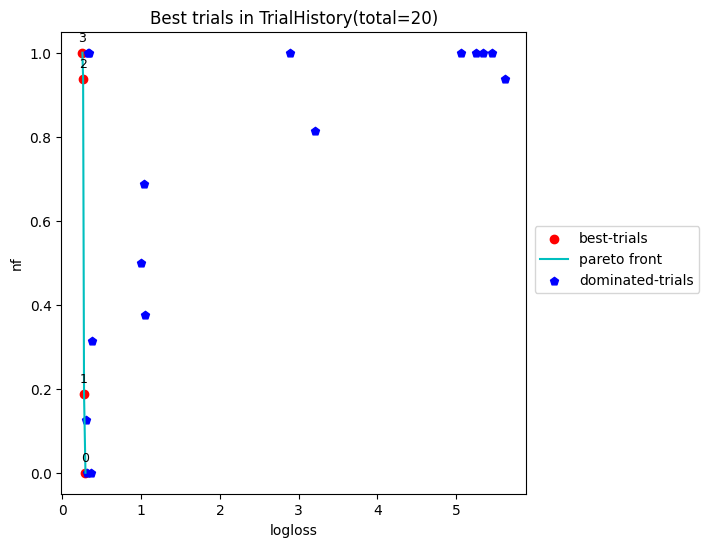

In [4]:
fig, ax  = experiment.hyper_model_.history.plot_best_trials()
fig.show()

## 5. Show features used by the pipeline model

NumOfFeatures can also used as a tool to show features used by arbitrary black box model.

In [8]:
from hypernets.model.objectives import NumOfFeatures

nof = NumOfFeatures(sample_size=100000)
X_test = df_train.copy().drop(['y'], axis=1)

nof.get_used_features(estimator=estimators[1], X_test=X_test)

['duration']